# Vorarbeiten

In [1]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt

pd.options.display.precision = 15

## Umgebungsvariablen

In [2]:
failure_datapath = '''D:/jupyter-notebooks/LANL_Earthquake_Prediction/failure/'''
train_data_path = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/all/train.csv'''
feature_data_path = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/all/earthquakeFeatures.csv'''

## Trainingsdaten laden

In [3]:
train_data = pd.read_csv(train_data_path, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

# Feature Extraction

Die Testsegmente bestehen jeweils aus 150.000 Messpunkte. Aus diesem Grund setzten wir die Fenstergrösse auch auf 150000 Messpunkte.

In [4]:
def generate_featureRow(acoustic_data, time_to_failure):
    
    strain_feature = []
    strain_feature.append(acoustic_data.mean())
    strain_feature.append(acoustic_data.std())
    strain_feature.append(acoustic_data.kurtosis())
    strain_feature.append(acoustic_data.skew())
    strain_feature.append(acoustic_data.min())
    strain_feature.append(acoustic_data.max())
    strain_feature.append(acoustic_data.quantile(0.01, interpolation='midpoint'))
    strain_feature.append(acoustic_data.quantile(0.05,interpolation='midpoint'))
    strain_feature.append(acoustic_data.quantile(0.95,interpolation='midpoint'))
    strain_feature.append(acoustic_data.quantile(0.99,interpolation='midpoint'))
    strain_feature.append(acoustic_data.abs().max())
    strain_feature.append(acoustic_data.abs().mean())
    strain_feature.append(acoustic_data.abs().std())
    
    strain_feature.append(time_to_failure.values[-1])
    
    return strain_feature

Das Fenster, mit der grösse 150000), wird durch das Trainingssignal geschoben mit einer geplanten Überlappung von 80%

In [5]:
def generate_Features(train,step, window_size=150000, ):
    init_idx = 0
    features = []

    while (init_idx + window_size < len(train)):
        window = train.iloc[init_idx:init_idx + window_size]
        features.append(generate_featureRow(window.acoustic_data,window.time_to_failure))
        init_idx += step

    return pd.DataFrame(features,dtype=np.float64,columns = ['mean','std','kurt','skew','min','max','1%q','5%q','95%q','99%q','absMax','absMean','absStd','time_to_failure'])

In [6]:
step = 150000
features = generate_Features(train_data,step)

In [7]:
features.shape

(4194, 14)

In [11]:
features.head()

,mean,std,kurt,skew,min,max,1%q,5%q,95%q,99%q,absMax,absMean,absStd,time_to_failure
0,4.884113333333334,5.101106130606765,33.662481293451094,-0.024061166628209,-98.0,104.0,-8.0,-2.0,11.0,18.0,104.0,5.576566666666666,4.333324673993449,1.4307971859
1,4.725766666666667,6.588823781946801,98.758517178736923,0.390560504371834,-154.0,181.0,-11.0,-2.0,12.0,21.0,181.0,5.734166666666667,5.732776965581381,1.3914988931
2,4.906393333333333,6.967397033524431,33.555211406928983,0.217390561445685,-106.0,140.0,-15.0,-3.0,13.0,26.0,140.0,6.152646666666667,5.895944714483795,1.3531960947
3,4.902240000000000,6.922305187180113,116.548171687628383,0.757277536411098,-199.0,197.0,-12.0,-2.0,12.0,22.0,199.0,5.933960000000000,6.061213600190591,1.3137978019
4,4.908720000000000,7.301110189758817,52.977904834406473,0.064531069271374,-126.0,145.0,-15.0,-2.0,12.0,26.0,145.0,6.110586666666666,6.329485313861190,1.2743995091


In [ ]:
# saving the dataframe 
df.to_csv(feature_data_path, header=False, index=False) 

# Create Model Workbench

## Imports

In [12]:
# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Modellauswahl

Als erste Orientierung bezüglich der ersten Modellauswahl, haben wir uns an machine_learning_map gehalten.
Quelle: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Support Vector Regression (SVR) using linear and non-linear kernels

In [14]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('regressor', SVR())])

In [25]:
param_grid = [
    {'regressor': [SVR(kernel='rbf',epsilon=.1)], 
     'preprocessing': [StandardScaler(), RobustScaler()],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [29]:
param_grid = [
    {'regressor': [SVR(kernel='linear')],
     'preprocessing': [StandardScaler(), RobustScaler()],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [15]:
param_grid = [
    {'regressor': [SVR(kernel='poly',epsilon=.1)],
     'preprocessing': [StandardScaler()],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__degree': [1,2],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [38]:
param_grid = [
    {'regressor': [SVR(kernel='rbf',epsilon=.1)], 
     'preprocessing': [StandardScaler()],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'regressor': [SVR(kernel='linear')],
     'preprocessing': [StandardScaler(), RobustScaler()],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'regressor': [SVR(kernel='poly',epsilon=.1)],
     'preprocessing': [StandardScaler(), RobustScaler()],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__degree': [1,2,3],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    features.iloc[:,0:13], features.iloc[:,-1], random_state=0, test_size=0.25)

In [ ]:
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

In [28]:
print('SVR(kernel=rbf')
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Test-set: mean absolute error : {:.2f}".format(mean_absolute_error(y_test, grid.predict(X_test))))

SVR(kernel=rbf
Best params:
{'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'regressor__C': 100, 'regressor__gamma': 0.01}

Best cross-validation score: -2.11
Test-set score: -2.12
Test-set: mean absolute error : 2.12


In [33]:
print('SVR(kernel=linear')
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Test-set: mean absolute error : {:.2f}".format(mean_absolute_error(y_test, grid.predict(X_test))))

SVR(kernel=linear
Best params:
{'preprocessing': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'regressor': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'regressor__C': 100, 'regressor__gamma': 0.001}

Best cross-validation score: -2.19
Test-set score: -2.21
Test-set: mean absolute error : 2.21


In [ ]:
print('SVR(kernel=poly')
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Test-set: mean absolute error : {:.2f}".format(mean_absolute_error(y_test, grid.predict(X_test))))

## GradientBoosting

Pipe with preprocessing and one regressor

In [13]:
pipe = Pipeline([('preprocessing',PolynomialFeatures()), ('regressor', GradientBoostingRegressor())])

In [14]:
param_grid = [
    {'regressor': [GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=1,random_state=0, loss='ls')],
     'regressor__loss':['ls', 'lad', 'huber', 'quantile'],
     'preprocessing': [None]}]

Split data into train and test data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    features.iloc[:,0:13], features.iloc[:,-1], random_state=0, test_size=0.25)

Find best parameter with grid search

In [16]:
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'regressor': [GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
    ...warm_start=False)], 'regressor__loss': ['ls', 'lad', 'huber', 'quantile'], 'preprocessing': [None]}],
       pre_dispatch='2*n_jobs', refit

Print Result

In [17]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Test-set: mean absolute error : {:.2f}".format(mean_absolute_error(y_test, grid.predict(X_test))))

Best params:
{'preprocessing': None, 'regressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False), 'regressor__loss': 'lad'}

Best cross-validation score: -2.12
Test-set score: -2.13
Test-set: mean absolute error : 2.13


## Plot Feature Importance

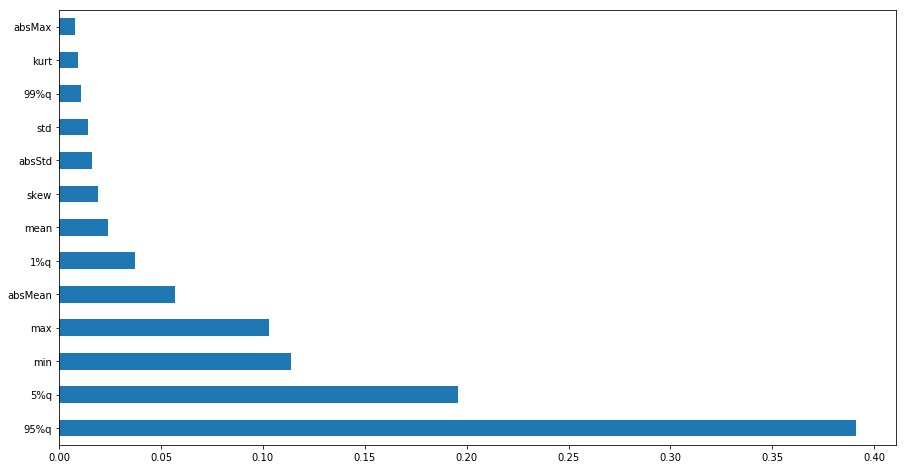

In [23]:
(pd.Series(grid.best_estimator_.named_steps['regressor'].feature_importances_, index=X_train.columns)
   .nlargest(13)
   .plot(kind='barh',figsize=(15, 8))) 
#quelle: https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names

In [ ]:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py

# Open Points

gridsearch mit mae?

# To Do

## New Feature

 - Signal: phase, frequency, angular frequency, wavelength and a period. --> new features for mean / std / skew / kurt / percentile https://pythontic.com/visualization/signals/magnitude%20spectrum

 - RMS: root mean square of a signal (Effektivwert): https://de.wikipedia.org/wiki/Effektivwert
 - https://librosa.github.io/librosa/feature.html (RMS/etc..)


## Model selection
 - Random forrest
 - Other GradientBoost (AdaBoost)

 - Feed Forward NN (with Karas)
 - Reccurent Neuronal Net: LSTM (with Karas)
 - Convolutional NN

## Quellen
### Spektrogramm
A spectrogram explains how the signal strength is distributed in every frequency found in the signal.
 - Funny overview spectrogram: https://www.summerrankin.com/dogandponyshow/2017/10/16/catdog
 - Plotting A Spectrogram: https://pythontic.com/visualization/signals/spectrogram (Feature / CNN)                     https://vane.pl/sampling-audio-files-with-python/
 - How to convert a spectrogram to 3d plot. Python: https://stackoverflow.com/questions/48598829/how-to-convert-a-spectrogram-to-3d-plot-python
 - Plotting A periodogram: https://www.elenacuoco.com/2016/09/22/power-spectral-density/
 - Allgemeine Info zu Vibration Analysis: FFT, PSD, and Spectrogram Basics
https://blog.mide.com/vibration-analysis-fft-psd-and-spectrogram